In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
# Brining in tensorflow datasets for fashion mnist 
import tensorflow_datasets as tfds
# Bringing in matplotlib for viz stuff
from matplotlib import pyplot as plt

In [4]:
# Use the tensorflow datasets api to bring in the data source
ds = tfds.load('fashion_mnist', split='train')

In [5]:
type(ds)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [8]:
# iteratorun asıl yaptığı şey bütün dataset'ini ram'e yklemek yerine her bir seferinde batch size akdarını ram'e getirerek 
# dataset üzeirnde iterate etmemize yarıyor.
ds.as_numpy_iterator().next()['image']

array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 18],
        [ 77],
        [227],
        [227],
        [208],
        [210],
        [225],
        [216],
        [ 85],
        [ 32],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 61],
        [100],
        [ 97],
        [ 80],
        [ 57],
        [117],
        [227],
        [238],
        [115],
        [ 49],
        [ 78],
        [106],
        [108],
        [ 71],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 81],
        [105],
        [ 80],
        [ 69],
      

# 2. Viz Data and Build Dataset

In [5]:
# Do some data transformation
import numpy as np

In [6]:
# Setup connection aka iterator
dataiterator = ds.as_numpy_iterator()

In [7]:
# Getting data out of the pipeline
dataiterator.next()['image']

array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 18],
        [ 77],
        [227],
        [227],
        [208],
        [210],
        [225],
        [216],
        [ 85],
        [ 32],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 61],
        [100],
        [ 97],
        [ 80],
        [ 57],
        [117],
        [227],
        [238],
        [115],
        [ 49],
        [ 78],
        [106],
        [108],
        [ 71],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 81],
        [105],
        [ 80],
        [ 69],
      

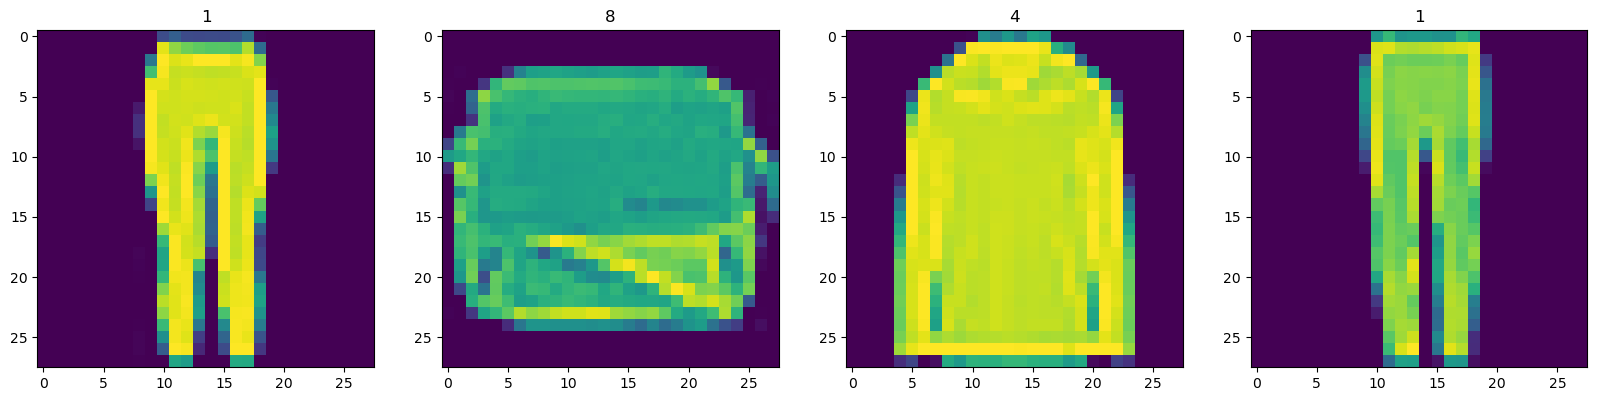

In [8]:
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx in range(4): 
    # Grab an image and label
    sample = dataiterator.next()
    # Plot the image using a specific subplot 
    # squuze fonksiyonu bir boyut küçültüyor elizdeki bu fotoğrafin boyutunu (28,28,1) iken (28,28)'e düşürüyoruz.
    ax[idx].imshow(np.squeeze(sample['image']))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(sample['label'])

In [9]:
# Scale and return images only
# Bunu yapmamızın amacı data seti ile çalışırken biraz daha hızlı train olması, cunku sanirim 0-1 arasian scale edilmis sayilarla
# daha hizli calisiyor modeller.
def scale_images(data): 
    image = data['image']
    return image / 255

### Burada yapilan kodun amaci iterator'dan once bir akç ayarlamalar yaparak iterator olusturmak
### Bazilari iterator'a etki ediyorken bazilari shuffle gibi sadece dataset'i karistirmaya yariyor.

In [10]:
# Reload the dataset 
ds = tfds.load('fashion_mnist', split='train')
# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images) 
# Cache the dataset for that batch 
ds = ds.cache()
# Shuffle it up 
ds = ds.shuffle(60000)
# Batch into 128 images per sample
# 128 tane gibi büyük bir sayı seçmemizin sebebi modele bu sample'ları verirken modelin herhangi bir şekilde bir tane 
# türe takılı kalıp sürekli onu genrate etmesini önelemk için.
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking 
ds = ds.prefetch(64)

# Building Model

In [11]:
# Bring in the sequential api for the generator and discriminator
# Sequential kullancağımız model bir tane inputa karşılık bir tane output üretmemize olanak sağlayan bir model
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
# Burada birden fazla layer var bu layerların her birini nöron olarak düşün. 
# Conv2D bize convuntional katmanın nöronunu verecek
# Dense klasik full connected nöron
# flatten sanırım bir boyut indirgemek için
# reshape istediğimiz bir şekilde scale etmek için 
# LeakyReLU activation function
# Dropout eğitim sırasında nörünların bir kaçının diğer katana geçerken geçersiz olması. Kullanılmayacak yani.
# UpSampling2D ise yine fotoğraflarımızın upscale edimesine yarayacakmış
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

## GENERATOR

In [45]:
def build_generator(): 
    model = Sequential()
    
    # 128 tane gibi büyük bir sayı seçmemizin sebebi modele bu sample'ları verirken modelin herhangi bir şekilde bir tane 
    # türe takılı kalıp sürekli onu generate etmesini önlemek için. Ya da ben öyle anladım emin olamadım şimdi
    
    # Takes in random values and reshapes it to 7x7x128
    # Beginnings of a generated image
    
    #Burada 7*7 olmasının sebebi 128 tane rastgele sayıyı 7*7'lik matris gibi reshape etmek istiyoruz.
    model.add(Dense(7*7*128, input_dim=128))
    # Buradaki parametre olarak verilen 0.2 eğerki bu activation fonksiyonun grafiğini açacak olursan oradaki <0 eğimi tanımlıyor.
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    
    # Upsampling block 1 
    # Buradaki upsampling2D bizim 7*7*128'lik olan tensorumuzu 14*14*128'lik bir hale getirecek. 
    # Yani boyutunu iki katına çıakrmak çin bunu kullanıyoruz.
    model.add(UpSampling2D())
    # Burada yoğunluk ekliyor bu katman dedi. Sanırım yani derinlik katmanı olan 128'i hangi boyutlarda tutmak istediğimizi 
    # ayarlamamıza olanak sağlyıor. Istersek elbetteki aynı 128 olarak bırakabiliyoruz.
    # En sonda bu Conv2D'yi kullanarak derinliği 1'e düşürmüş.
    # ASlında şunu da dedi upsacale yapıp kopyalarak iki katına çıkardığımız imagelerin kopyalanmışlarını biraz daha transformate
    # etmek için kullanıyormuşuz.
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2 
    model.add(UpSampling2D())
    # burada 14*14*128 -> 28*28*128 yaptık.
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    # Activation fonksiyonu olarak sigmoid kullandık ki sonuç olarak bizlere 0 veya 1 döndürsün.
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model

In [46]:
generator = build_generator()

In [47]:
# Bu satır bizlere modelmizin bir özetini göstermeye yarıyor.
generator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_4 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_4 (UpSamplin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                      

1/1 [==============================] - 0s 55ms/step


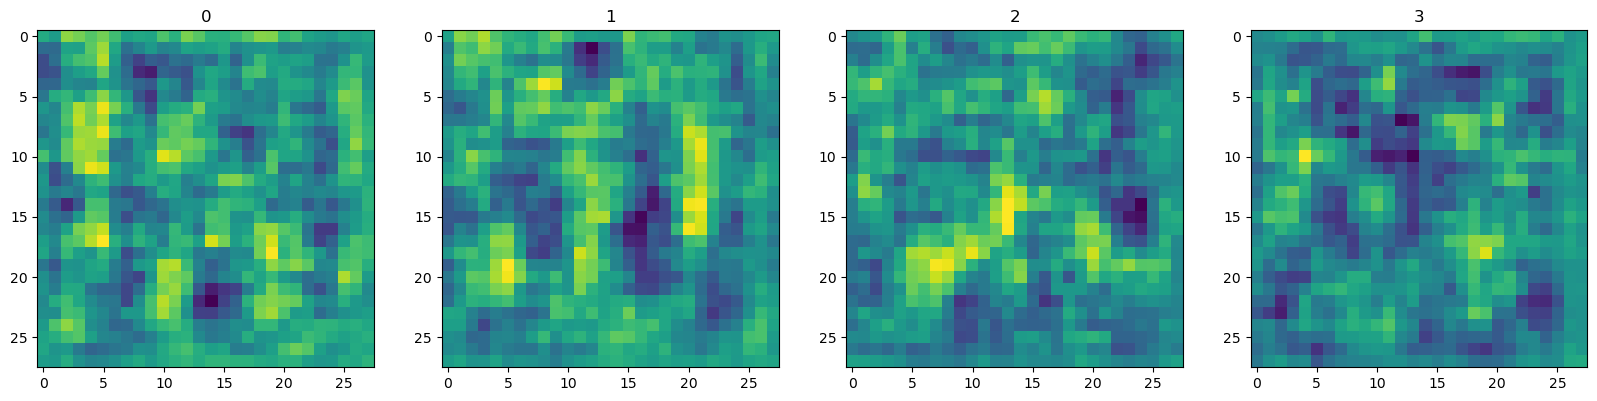

In [36]:
# Generate new fashion
# 4 tane 128'e 1 boyutlarında 
img = generator.predict(np.random.randn(4,128,1))
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx, img in enumerate(img): 
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(idx)

## DISCIRIMINATOR

In [54]:
def build_discriminator(): 
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model 

In [55]:
discriminator = build_discriminator()

In [56]:
discriminator.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_10 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_11 (Dropout)        (None, 20, 20, 64)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 16, 16, 128)      

In [58]:
# img'in shape'inin ( 1,28,28,1) gibi olması gerek yani 4 boyuttan oluşmalı.
# aslında 4 boyut olmasının sebebi 1 tane 28 , 28 , 1'lik dizi vermek demek. Bu da derinliği 1 olan 28'e 28'lik fotograf demek. 
discriminator.predict(img)

1/1 [==============================] - 0s 125ms/step


array([[0.50412565]], dtype=float32)

# 4. Construct Training Loop
### 4.1 Setup Losses and Optimizers

In [59]:
# Adam is going to be the optimizer for both
# Gradient descent algoritması için kullanılıyor bu adam sanırım ya da esdegeri islevi yerine getiriyor.
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss for both 
from tensorflow.keras.losses import BinaryCrossentropy

In [60]:
# Generator'un ogrenme oranını yani Andrew NG kursunda gördüğüm alpha oranını discriminator'dan daha iyi yapıyoruz ki 
# Minimum noktasını bulma hızı generator için discriminator'dan hızlı olsun. Böylesi daha optimum bir sonuc veriyormus. 
g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.00001) 

g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

# 4.2 Build Subclassed Model

In [61]:
# Importing the base model class to subclass our training step 
# Bu sınıf base class olduğundan modele etki edebileceğimiz şeyler daha fazla yani sadece katman eklemekten çok daha 
# fazla şeyler gerçekleştirebiliriz
from tensorflow.keras.models import Model

In [62]:
# Bu sınıf Model sınıfından kalıtım almış bir alt sınıf olacak ve noraml bir modelin eğitilmesinden farklı olarak modelimizi 
# eğiteceğimizden dolayı burada fit ve compile gibi modeli eğitmekten kullanılan hazır fonksiyonalrı kendimiz tekrardan yazacağız.

class FashionGAN(Model): 
    # args ve kwargs kullanmamızın sebebi eğerki base sınfın constructor'ına bir parametre yollamak istersek diye
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt  
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        # Get the data 
        # Eğitimimize başlıyoruz burada gerçek ve fake imageleri alarak eğitime başlayacağız.
        real_images = batch
        # fake images'imizi generator'ımız sayesinde oluşturuyoruz.
        # predict yaptığmız eğitim yapmadığmız için eğitim parametresine false verdik.
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            # Burada eğitimi açtık ki eğitilebilsinler.
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            # zeros_like verilen bir dizi gibi 0'lar oluşturur. ones_like ise 1'ler oluşturur.
            # axis=0 ile bunları alt alta birleştirdik.
            # Burada bilerek dogru cevapladıklarını yanlış cevaplamış gibi, yanlış cevapladıklarını ise doğru cevaplamış gibi
            # label'ladık ki ogrenme surecinde generator'ın gosterdiklerini dogru zannetsin.
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            # Burada eğitimin içerisine biraz noise ekleyerek ..... yapmaya çalışıyoruz
            # Amacımız dicriminator olanın kafasını karıştırmak
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            # Burada herbir değer için gerçek ve tahmn edilen sonuçları loss fonksiyonuna verip bir çıktı alıyoruz
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn learn 
        # Burada total_loss yani yanılma payını vererek bütün verileri de verdik aynı zamanda gradient desxent'i hesapladık.
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        # Burada ise bu gradient descent'i optimizer'ımıza vererek alpha rate'i kullanarak modelimizi daha doğru sonuçlar 
        # vermesi için optimize ettik.
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            # 128 tane fake image yaratarak discriminatoyr'ın tahmine temwsie göre  generator'ı geri besleyeceğiz.
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
                                        
            # Create the predicted labels
            # Burada tahmin ettiriyioruz.
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            # Burada birazcık ters bir işlem yapıyoruz şöyle ki:
            # Eğerki discriminator fake image'lere real etkiketi verirse generator'ı ödüllendireceğiz.
            # Unutmaki bizim 0'larımız real 1'lerimiz fake idi.
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        # discriminator için yaptığımız optimizer işlemlernina aynısını burada da yaptık
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        # burada bu ikisini döndürmemizin amacı grafiğe dökerek iyileşmeleri gözlemlemek istiyor oluşumuz
        # her bir seferde yanılmaların azalarak loss'un da azalmasını bekliyoruz.
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [63]:
# Create instance of subclassed model
# Burada bilgidiğin sınfımızdan bir örnek oluşturduk.
fashgan = FashionGAN(generator, discriminator)

In [64]:
# Compile the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

In [65]:
# Fotoğraf dosya yolunu vermek için daha kolay yollar sağladığı os için kullanıyoruz.
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [66]:
# Trainin yaparken modeli daha iyi gözlemlemek için trainin esnasında çağırmasını istediğimiz 
# fonksiyonu bu sınıf içerisinde toparladık.
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
    # Burada oluşturualn imageleri dosya olarak kaydedeceğiz.
    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

### 4.3 Train

In [67]:
# Recommend 2000 epochs
# burada 2000 yerine 20 verdik çünkü uzun süreceğini düşündük.
# Ayrıca yukarıda da bahsettiğim gibi :
# Trainin yaparken modeli daha iyi gözlemlemek için trainin esnasında çağıramsıı istediğimiz fonksiyonu bu sınıf içerisinde toparladık.
hist = fashgan.fit(ds, epochs=20, callbacks=[ModelMonitor()])

# gözlemlerken farketmek istediğimiz şeylerden birisi de  d_loss ve g_loss'un birbirlerine yakın değerlerde gidip gelmeleri 
# Eğerki biri diğerinden daha önce aşağılara gidiyorsa sıkıntı var demektir.
# Biri çok hızlı eğitiliyorken diğeri çok yavaş kalıyordur

Epoch 1/20
239/469 [==============>...............] - ETA: 25:44 - d_loss: 0.5710 - g_loss: 0.7012


KeyboardInterrupt



### 4.4 Review Performance

In [ ]:
# Modelin eğitilme aşamasındaki loss function'larını grafik üzeirnde görüntülemek sitersen
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

# 5. Test Out the Generator
### 5.1 Generate Images

In [ ]:
# hazır bir modelden önceden eğitilmiş ağırlıkları kopyalamak için.

# generator.load_weights(os.path.join('archive', 'generatormodel.h5'))

In [ ]:
# eğittiğimiz modelden resim üretmesini istiyoruz.
imgs = generator.predict(tf.random.normal((16, 128, 1)))

In [ ]:
# Eğittiğimiz mdoelin reismlerini matplotlib ile gösteriyoruz.
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

### 5.2 Save the Model

In [ ]:
# Modeli kaydetmek için 
generator.save('generator.h5')
discriminator.save('discriminator.h5')